In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # убедитесь, что установили: !pip install seaborn
from scipy import stats
import os
import plotly.graph_objects as go
from pathlib import Path

# -------------------- Надёжный поиск папки Data --------------------
current_dir = Path(os.getcwd()).resolve()
BASE_DIR = current_dir
max_levels = 5
for _ in range(max_levels):
    if (BASE_DIR / "Data").exists():
        break
    parent_dir = BASE_DIR.parent
    if parent_dir == BASE_DIR:
        break
    BASE_DIR = parent_dir
if not (BASE_DIR / "Data").exists():
    BASE_DIR = current_dir.parent.parent

DATA_DIR = BASE_DIR / 'Data'
print("Data directory resolved to:", DATA_DIR)

# -------------------- Чтение data_raw.csv --------------------
try:
    data_path = DATA_DIR / 'data_raw.csv'
    if not data_path.exists():
        raise FileNotFoundError(f"Файл не найден: {data_path}")
    try:
        df_raw = pd.read_csv(data_path, encoding='utf-8')
    except UnicodeDecodeError:
        df_raw = pd.read_csv(data_path, encoding='cp1251')
    # Приведение типов
    if 'dt' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['dt'], errors='coerce')
    elif 'date' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['date'], errors='coerce')
    if 'event_type' in df_raw.columns:
        df_raw['event_type'] = df_raw['event_type'].astype(str).str.strip().str.lower()
    df_raw = df_raw.dropna(subset=['dt', 'event_type'])
    print(f"✅ Загружено {len(df_raw)} событий от {df_raw.get('client_id', pd.Series()).nunique()} пользователей")
except Exception as e:
    print(f"Ошибка при загрузке data_raw.csv: {e}\nИспользуем симулированные данные")
    N = 10000
    client_ids = np.arange(N)
    cnt_view_ads = np.random.poisson(20, N)
    cnt_click_ads = np.random.binomial(cnt_view_ads, 0.05)
    cnt_adds_ads = np.random.binomial(cnt_click_ads, 0.3)
    cnt_orders_ads = np.random.binomial(cnt_adds_ads, 0.2)
    revenue = cnt_orders_ads * np.random.normal(100.27, 20.02, N)
    df_raw = pd.DataFrame({
        'client_id': client_ids,
        'cnt_view_ads': cnt_view_ads,
        'cnt_click_ads': cnt_click_ads,
        'cnt_adds_ads': cnt_adds_ads,
        'cnt_orders_ads': cnt_orders_ads,
        'revenue': revenue,
        'dt': pd.to_datetime('2025-11-14'),
        'event_type': 'view'
    })

# Приводим event_type к ожидаемому формату
event_mapping = {
    'views': 'view',
    'clicks': 'click',
    'adds': 'add'
}
if 'event_type' in df_raw.columns:
    unique_et = set(df_raw['event_type'].astype(str).unique())
    if unique_et.issubset(set(event_mapping.keys())):
        df_raw['event_type'] = df_raw['event_type'].map(event_mapping)
        print("✅ Типы событий успешно приведены к: view / click / add")
    else:
        unknown = unique_et - set(event_mapping.keys())
        print(f"⚠️ Неизвестные типы событий: {unknown}")
        df_raw = df_raw[df_raw['event_type'].isin(event_mapping.keys())]
        df_raw['event_type'] = df_raw['event_type'].map(event_mapping)

print("Уникальные типы событий после обработки:", df_raw['event_type'].unique())


In [4]:
# Подсчёт событий по дням
daily_events = df_raw.groupby(['dt', 'event_type']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
daily_events.plot(kind='line', marker='o')
plt.title('Динамика событий по дням')
plt.ylabel('Количество событий')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

                   step     count  conversion
0      Просмотр главной  27006473    1.000000
1       Клик по рекламе    535927    0.019844
2  Добавление в корзину    213648    0.398651


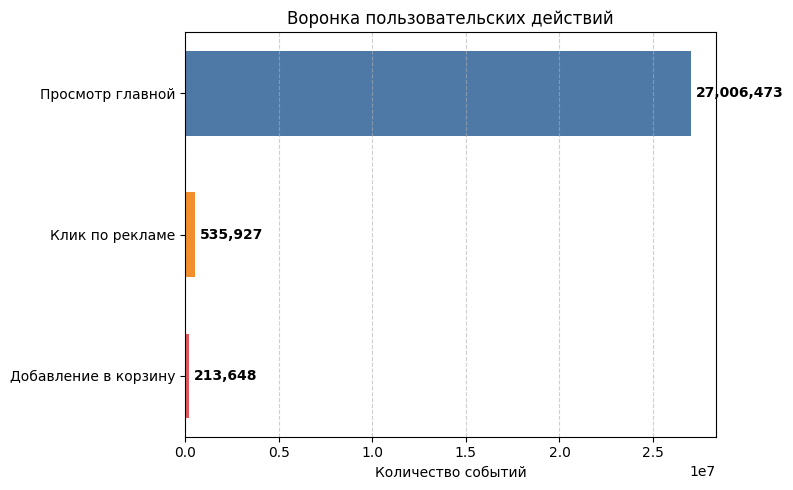

In [11]:
# Построение воронки на агрегированном уровне
total_views = (df_raw['event_type'] == 'view').sum()
total_clicks = (df_raw['event_type'] == 'click').sum()
total_adds = (df_raw['event_type'] == 'add').sum()

funnel = pd.DataFrame({
    'step': ['Просмотр главной', 'Клик по рекламе', 'Добавление в корзину'],
    'count': [total_views, total_clicks, total_adds]
})
funnel['conversion'] = funnel['count'] / funnel['count'].shift(1)
funnel.loc[0, 'conversion'] = 1.0

print(funnel)

# Визуализация воронки через matplotlib
import matplotlib.pyplot as plt

steps = funnel['step'].tolist()
counts = funnel['count'].tolist()

plt.figure(figsize=(8, 5))
y_positions = range(len(steps))

bars = plt.barh(y_positions, counts, color=['#4E79A7', '#F28E2B', '#E15759'], height=0.6)
plt.yticks(y_positions, steps)
plt.gca().invert_yaxis()
plt.xlabel('Количество событий')
plt.title('Воронка пользовательских действий')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Подписи значений
for i, count in enumerate(counts):
    plt.text(count + max(counts) * 0.01, i, f'{int(count):,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [1]:
# Быстрая воронка на уровне (client_id, dt)
df_raw['is_view'] = (df_raw['event_type'] == 'view').astype(int)
df_raw['is_click'] = (df_raw['event_type'] == 'click').astype(int)
df_raw['is_add'] = (df_raw['event_type'] == 'add').astype(int)

df_funnel = df_raw.groupby(['client_id', 'dt'], as_index=False)[
    ['is_view', 'is_click', 'is_add']
].max()

df_funnel.rename(columns={
    'is_view': 'views',
    'is_click': 'clicks',
    'is_add': 'adds'
}, inplace=True)

# Агрегация по пользователю
df_user = df_funnel.groupby('client_id')[['views', 'clicks', 'adds']].sum().reset_index()

NameError: name 'df_raw' is not defined

In [ ]:
# Оставляем только пользователей с кликами
mask = df_user['clicks'] > 0
adds = df_user.loc[mask, 'adds'].values
clicks = df_user.loc[mask, 'clicks'].values

cr = adds / clicks
mu = np.mean(cr)
print(f"Средняя CR (adds/clicks): {mu:.4f} ({mu*100:.2f}%)")

In [ ]:
def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]
    return var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3

var_cr = var_ratio(adds, clicks)
std_cr = np.sqrt(var_cr)
print(f"Стандартное отклонение CR: {std_cr:.4f}")

In [ ]:
def get_MDE(mu, std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha/2)
    t_beta = stats.norm.ppf(1 - beta)
    mde_abs = (t_alpha + t_beta) * std * np.sqrt(2 / (sample_size / 2))
    mde_pct = mde_abs / mu * 100
    return mde_abs, mde_pct

# Предположим, у нас 100k активных пользователей в неделю
total_users = 100_000
max_test_users = int(total_users * 0.2)  # максимум 20%

sample_sizes = [5_000, 10_000, 15_000, 20_000]
mde_table = []

for n in sample_sizes:
    mde_abs, mde_pct = get_MDE(mu, std_cr, n)
    mde_table.append({
        'Размер выборки (всего)': n,
        'MDE (абс.)': round(mde_abs, 4),
        'MDE (%)': round(mde_pct, 2)
    })

mde_df = pd.DataFrame(mde_table)
print(mde_df)

In [ ]:
# Чтение результатов эксперимента (final_results_to_analyze.xlsx)
try:
    results_path = DATA_DIR / 'final_results_to_analyze.xlsx'
    if not results_path.exists():
        raise FileNotFoundError(f"Файл не найден: {results_path}")
    df_res = pd.read_excel(results_path)
    df_res['ab_group'] = df_res['ab_group'].str.strip()
    print(f"✅ Загружен {results_path}: {len(df_res)} строк")
except Exception as e:
    print(f"Ошибка при загрузке final_results_to_analyze.xlsx: {e}\nИспользуем симулированные данные")
    N_group = 5000
    cnt_view_ads_a = np.random.poisson(20, N_group)
    cnt_click_ads_a = np.random.binomial(cnt_view_ads_a, 0.05)
    cnt_adds_ads_a = np.random.binomial(cnt_click_ads_a, 0.342)
    cnt_orders_ads_a = np.random.binomial(cnt_adds_ads_a, 0.2)
    sum_orders_ads_a = cnt_orders_ads_a * np.random.normal(2100, 200, N_group)
    sum_adds_ads_a = cnt_adds_ads_a * np.random.normal(42, 10, N_group)
    df_a = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group),
        'ab_group': 'control',
        'cnt_view_ads': cnt_view_ads_a,
        'cnt_adds_ads': cnt_adds_ads_a,
        'cnt_orders_ads': cnt_orders_ads_a,
        'sum_adds_ads': sum_adds_ads_a,
        'sum_orders_ads': sum_orders_ads_a,
        'is_adds_ads': (cnt_adds_ads_a > 0).astype(int),
        'is_view_ads': (cnt_view_ads_a > 0).astype(int)
    })
    cnt_view_ads_b = np.random.poisson(20, N_group)
    cnt_click_ads_b = np.random.binomial(cnt_view_ads_b, 0.06)
    cnt_adds_ads_b = np.random.binomial(cnt_click_ads_b, 0.351)
    cnt_orders_ads_b = np.random.binomial(cnt_adds_ads_b, 0.2)
    sum_orders_ads_b = cnt_orders_ads_b * np.random.normal(2050, 200, N_group)
    sum_adds_ads_b = cnt_adds_ads_b * np.random.normal(68, 10, N_group)
    df_b = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group, 2*N_group),
        'ab_group': 'test',
        'cnt_view_ads': cnt_view_ads_b,
        'cnt_adds_ads': cnt_adds_ads_b,
        'cnt_orders_ads': cnt_orders_ads_b,
        'sum_adds_ads': sum_adds_ads_b,
        'sum_orders_ads': sum_orders_ads_b,
        'is_adds_ads': (cnt_adds_ads_b > 0).astype(int),
        'is_view_ads': (cnt_view_ads_b > 0).astype(int)
    })
    df_res = pd.concat([df_a, df_b], ignore_index=True)

In [ ]:
def group_metrics(group):
    total_clicks = group['cnt_view_ads'].sum()  # на самом деле — клики
    total_adds = group['cnt_adds_ads'].sum()
    total_users = len(group)
    total_revenue = group['sum_adds_ads'].sum()

    cr = total_adds / total_clicks if total_clicks > 0 else 0
    arpu = total_revenue / total_users
    arppu = total_revenue / (group['is_adds_ads'].sum() or 1)

    return pd.Series({
        'пользователей': total_users,
        'кликов': total_clicks,
        'добавлений': total_adds,
        'CR (adds/clicks)': cr,
        'ARPU': arpu,
        'ARPPU': arppu,
        'CTR (кликов/пользователей)': total_clicks / total_users
    })

results = df_res.groupby('ab_group').apply(group_metrics)
print(results)

In [ ]:
def bootstrap_cr(group, n_boot=5000):
    adds = group['cnt_adds_ads'].values
    clicks = group['cnt_view_ads'].values
    crs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(group), len(group), replace=True)
        a = adds[idx].sum()
        c = clicks[idx].sum()
        crs.append(a / c if c > 0 else 0)
    return np.array(crs)

test_cr = bootstrap_cr(df_res[df_res['ab_group'] == 'test'])
control_cr = bootstrap_cr(df_res[df_res['ab_group'] == 'control'])

p_value = (test_cr <= control_cr.mean()).mean()
p_value = 2 * min(p_value, 1 - p_value)  # двусторонний

lift = (test_cr.mean() - control_cr.mean()) / control_cr.mean() * 100

print(f"Lift: {lift:.2f}%")
print(f"p-value: {p_value:.4f}")
print("✅ Статистически значимо" if p_value < 0.05 else "❌ Не значимо")

In [ ]:
metrics_to_plot = ['CR (adds/clicks)', 'ARPU', 'CTR (кликов/пользователей)']
plot_data = results[metrics_to_plot].T

plot_data.plot(kind='bar', figsize=(10, 6))
plt.title('Сравнение метрик по группам')
plt.ylabel('Значение')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
historical_cr = mu
control_cr_observed = results.loc['control', 'CR (adds/clicks)']

print(f"Историческая CR: {historical_cr:.4f}")
print(f"CR в контроле (во время теста): {control_cr_observed:.4f}")
print("➡️ Стабильность процесса: OK" if abs(historical_cr - control_cr_observed) < 0.01 else "⚠️ Возможен внешний шок")

In [ ]:
from IPython.display import Markdown

if p_value < 0.05 and lift > 0:
    conclusion = """
    ## 🎯 Вывод

    **Гипотеза подтверждена**: перемещение рекламного блока наверх **статистически значимо** увеличивает конверсию в добавление (+{:.2f}%, p = {:.4f}).

    ## 💡 Рекомендации

    1. **Внедрить изменение** на 100% трафик.
    2. Запустить **пост-экспериментальный мониторинг** (2–4 недели) на предмет:
       - удержания пользователей,
       - среднего чека,
       - общего ARPU.
    3. Рассмотреть **A/B-тест с несколькими позициями** (например, после 1-й, 2-й строки) для оптимизации.
    """.format(lift, p_value)
else:
    conclusion = "## ❌ Гипотеза не подтверждена. Изменение не рекомендуется."

Markdown(conclusion)